# Accessibility Analysis

- This analysis will measure accessibility to schools and hospitals
- origins are derived from 100m grid blocks coming from WorldPop
- the accessibility measure is the distance to the nearest facility in meters

## Inputs:

#### origins: derived from a WorldPOP raster using the 'Raster pixels to Points' tool in QGIS 3, and saved as a shapefile
#### destinations: The combination of POIs from Overpass as points and centroids of polygons called through the GOSTNets OSMNX_POIs library.
#### The admin AOI will be used to create a bounding box to download the road network via OSMNX


### Import libraries

In [152]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [153]:
# Get reference to OSMNX_POIs
sys.path.append(r'../../GOST_PublicGoods/')
from Market_Access import OSMNX_POIs

In [154]:
# Get reference to GOSTNets
sys.path.append(r'../../GOSTnets')
import GOSTnets as gn

In [155]:
inputFolder = r'input_folder'
# define output folder
outputFolder = r'output_folder'
# define road graph
roadGraph = os.path.join(inputFolder, "OSM_Roads.pickle")

In [156]:
# import extent
city_extent = gpd.read_file("../admin/Buffalo_City.shp")

In [157]:
# make sure crs is 4326
print(city_extent.crs)

epsg:4326


In [158]:
extent = box(*city_extent.total_bounds)

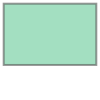

In [159]:
extent

## We will extract OSM POIs

In [160]:
schools_query = OSMNX_POIs.AmenityObject('education', extent, ['school', 'kindergarten','university', 'college'], inputFolder)        

In [161]:
health_query = OSMNX_POIs.AmenityObject('health ', extent, ['clinic','pharmacy','hospital','health'], inputFolder)      

In [162]:
schools_query.GenerateOSMPOIs()

../../GOST_PublicGoods\Market_Access\OSMNX_POIs.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid


,osmid,geometry,amenity,name,element_type,wikidata,designation,source,addr:postcode,addr:street,...,phone,website,access,barrier,nodes,created_by,wikipedia,building,religion,isced
0,621169044,POINT (27.91170 -32.98514),school,Port Rex Technical High,node,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,621169045,POINT (27.91586 -32.98572),school,Hudson Park High,node,Q5928799,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,621169047,POINT (27.91603 -32.98316),school,Hudson Park Primary,node,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1717717357,POINT (27.89951 -32.99601),college,East London FET College,node,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1828180114,POINT (27.88753 -33.00866),school,Sinovuyo School,node,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,568073885,POINT (27.91793 -32.96285),school,Abbotsford Christian School,way,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"[5466235602, 5466235603, 5466235604, 546623560...",NaN,NaN,NaN,christian,NaN
122,682937226,POINT (28.00985 -32.93696),school,Gonubie Primary School,way,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"[6396667295, 6396667294, 6396667296, 639666729...",NaN,NaN,NaN,NaN,NaN
123,682983173,POINT (27.99184 -32.95384),school,Mzamowethu Public School,way,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"[6397177213, 2155563800, 6397177801, 273184217...",NaN,NaN,NaN,NaN,NaN
124,743222432,POINT (27.90558 -33.03408),school,West Bank High School,way,Q20982086,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"[6956894886, 6956894887, 6956894888, 432678422...",NaN,NaN,NaN,NaN,2-3


In [163]:
health_query.GenerateOSMPOIs()

../../GOST_PublicGoods\Market_Access\OSMNX_POIs.py:75: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygons['geometry'] = polygons.centroid


,osmid,geometry,amenity,dispensing,name,element_type,addr:housenumber,addr:street,phone,drive_through,healthcare,nodes,wikidata,wikipedia,building,emergency
0,1492604520,POINT (27.93965 -32.96707),pharmacy,yes,Link Pharmacy,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1508385847,POINT (27.89983 -32.97111),pharmacy,yes,Dischem Hemingways,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1729529752,POINT (27.90444 -32.98322),pharmacy,NaN,Clicks,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1730250053,POINT (27.38544 -32.87416),pharmacy,NaN,Clicks,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2298902321,POINT (27.88952 -32.97801),clinic,NaN,Cambridge Clinic (Sprigg Street Clinic),node,30,Sprigg Street,+27 43 726 0142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2305252692,POINT (27.89366 -32.98034),pharmacy,NaN,Alphapharm Cambridge Pharmacy,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2305604143,POINT (27.91244 -32.99362),pharmacy,NaN,Link Berea Pharmacy,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2305604159,POINT (27.90659 -32.99352),clinic,NaN,Medicross East London,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2306374066,POINT (27.88067 -33.01235),clinic,NaN,Pefferville Clinic,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2306374071,POINT (27.88609 -33.00785),clinic,NaN,Duncan Village Community Health Clinic,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
schools_query.RemoveDupes(0.0005)

../../GOST_PublicGoods\Market_Access\OSMNX_POIs.py:91: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf['geometry'].buffer(buf_width)
C:\Users\war-machine\Anaconda2\envs\gostnets2\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,access,addr:postcode,addr:street,amenity,barrier,buffer,building,created_by,designation,element_type,...,name,nodes,opening_hours,osmid,phone,religion,source,website,wikidata,wikipedia
0,NaN,NaN,NaN,school,NaN,"POLYGON ((27.9121977 -32.9851427, 27.912195292...",NaN,NaN,NaN,node,...,Port Rex Technical High,NaN,NaN,6.211690e+08,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,school,NaN,"POLYGON ((27.9163605 -32.9857187, 27.916358092...",NaN,NaN,NaN,node,...,Hudson Park High,NaN,NaN,6.211690e+08,NaN,NaN,NaN,NaN,Q5928799,NaN
2,NaN,NaN,NaN,school,NaN,"POLYGON ((27.9165321 -32.9831628, 27.916529692...",NaN,NaN,NaN,node,...,Hudson Park Primary,NaN,NaN,6.211690e+08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,college,NaN,"POLYGON ((27.9000102 -32.9960097, 27.900007792...",NaN,NaN,NaN,node,...,East London FET College,NaN,NaN,1.717717e+09,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,school,NaN,"POLYGON ((27.8880259 -33.0086629, 27.888023492...",NaN,NaN,NaN,node,...,Sinovuyo School,NaN,NaN,1.828180e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,NaN,NaN,NaN,school,NaN,"POLYGON ((27.9983684095124 -32.94620749320773,...",NaN,NaN,NaN,way,...,Gonubie High School,"[4270567954, 4270567955, 4270567956, 639666973...",NaN,4.278887e+08,NaN,NaN,NaN,NaN,NaN,NaN
112,NaN,NaN,NaN,school,NaN,POLYGON ((27.91842663757188 -32.96285243978603...,NaN,NaN,NaN,way,...,Abbotsford Christian School,"[5466235602, 5466235603, 5466235604, 546623560...",NaN,5.680739e+08,NaN,christian,NaN,NaN,NaN,NaN
113,NaN,NaN,NaN,school,NaN,"POLYGON ((28.010350787836 -32.93695991468628, ...",NaN,NaN,NaN,way,...,Gonubie Primary School,"[6396667295, 6396667294, 6396667296, 639666729...",NaN,6.829372e+08,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,school,NaN,POLYGON ((27.99233665940623 -32.95383801621114...,NaN,NaN,NaN,way,...,Mzamowethu Public School,"[6397177213, 2155563800, 6397177801, 273184217...",NaN,6.829832e+08,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
health_query.RemoveDupes(0.0005)

../../GOST_PublicGoods\Market_Access\OSMNX_POIs.py:91: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['buffer'] = gdf['geometry'].buffer(buf_width)
C:\Users\war-machine\Anaconda2\envs\gostnets2\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,addr:housenumber,addr:street,amenity,buffer,building,dispensing,drive_through,element_type,emergency,geometry,healthcare,name,nodes,osmid,phone,wikidata,wikipedia
0,NaN,NaN,pharmacy,"POLYGON ((27.9401497 -32.9670692, 27.940147292...",NaN,yes,NaN,node,NaN,POINT (27.9396497 -32.9670692),NaN,Link Pharmacy,NaN,1.492605e+09,NaN,NaN,NaN
1,NaN,NaN,pharmacy,"POLYGON ((27.9003329 -32.97110849999999, 27.90...",NaN,yes,NaN,node,NaN,POINT (27.8998329 -32.97110849999999),NaN,Dischem Hemingways,NaN,1.508386e+09,NaN,NaN,NaN
2,NaN,NaN,pharmacy,"POLYGON ((27.9049402 -32.9832249, 27.904937792...",NaN,NaN,NaN,node,NaN,POINT (27.9044402 -32.9832249),NaN,Clicks,NaN,1.729530e+09,NaN,NaN,NaN
3,NaN,NaN,pharmacy,"POLYGON ((27.3859443 -32.8741564, 27.385941892...",NaN,NaN,NaN,node,NaN,POINT (27.3854443 -32.8741564),NaN,Clicks,NaN,1.730250e+09,NaN,NaN,NaN
4,30,Sprigg Street,clinic,"POLYGON ((27.8900227 -32.97801460000001, 27.89...",NaN,NaN,NaN,node,NaN,POINT (27.8895227 -32.97801460000001),NaN,Cambridge Clinic (Sprigg Street Clinic),NaN,2.298902e+09,+27 43 726 0142,NaN,NaN
5,NaN,NaN,pharmacy,"POLYGON ((27.8941591 -32.98034059999999, 27.89...",NaN,NaN,NaN,node,NaN,POINT (27.8936591 -32.98034059999999),NaN,Alphapharm Cambridge Pharmacy,NaN,2.305253e+09,NaN,NaN,NaN
6,NaN,NaN,pharmacy,"POLYGON ((27.912941 -32.9936216, 27.9129385923...",NaN,NaN,NaN,node,NaN,POINT (27.912441 -32.9936216),NaN,Link Berea Pharmacy,NaN,2.305604e+09,NaN,NaN,NaN
7,NaN,NaN,clinic,"POLYGON ((27.9070934 -32.99351529999999, 27.90...",NaN,NaN,NaN,node,NaN,POINT (27.9065934 -32.99351529999999),NaN,Medicross East London,NaN,2.305604e+09,NaN,NaN,NaN
8,NaN,NaN,clinic,"POLYGON ((27.8811727 -33.0123519, 27.881170292...",NaN,NaN,NaN,node,NaN,POINT (27.8806727 -33.0123519),NaN,Pefferville Clinic,NaN,2.306374e+09,NaN,NaN,NaN
9,NaN,NaN,clinic,"POLYGON ((27.8865891 -33.00784869999999, 27.88...",NaN,NaN,NaN,node,NaN,POINT (27.8860891 -33.00784869999999),NaN,Duncan Village Community Health Clinic,NaN,2.306374e+09,NaN,NaN,NaN


In [166]:
# warning: might not want to include the 'osmid' field because it may contain lists
school_destinations = schools_query.df[['amenity','geometry','name']]
health_destinations = health_query.df[['amenity','geometry','name']]

In [167]:
school_destinations[:3]

,amenity,geometry,name
0,school,POINT (27.9116977 -32.9851427),Port Rex Technical High
1,school,POINT (27.9158605 -32.9857187),Hudson Park High
2,school,POINT (27.9160321 -32.9831628),Hudson Park Primary


In [168]:
# save the facilities as a shapefile
# if not os.path.exists(outputFolder + '/osm_infrastructure/OSM_schools.shp'):

# convert to GeoDataFrame
school_destinations_gpd = gpd.GeoDataFrame(school_destinations, crs = "epsg:4326", geometry = 'geometry')
school_destinations_gpd.to_file(outputFolder + '/osm_infrastructure/osm_schools.shp')

health_destinations_gpd = gpd.GeoDataFrame(health_destinations, crs = "epsg:4326", geometry = 'geometry')
health_destinations_gpd.to_file(outputFolder + '/osm_infrastructure/osm_health.shp')

## We will extract the Roads and convert into a graph

In [169]:
# This is the section where we can adjust the road speeds
if not os.path.exists(roadGraph):
    extent = box(*city_extent.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    # save the largerst subgraph
   
    # compatible with NetworkX 2.4
    list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.strongly_connected_components(G))
    max_graph = None
    max_edges = 0
    for i in list_of_subgraphs:
        if i.number_of_edges() > max_edges:
            max_edges = i.number_of_edges()
            max_graph = i

    # set your graph equal to the largest sub-graph
    G = max_graph

    nx.write_gpickle(G, roadGraph)
else:
    G = nx.read_gpickle(roadGraph)    
    G = gn.convert_network_to_time(G, 'length')

### Inspect the road graph as a shapefile

In [170]:
roads = gn.edge_gdf_from_graph(G)

In [171]:
roads[:2]

,stnode,endnode,time,highway,lanes,tunnel,bridge,oneway,mode,maxspeed,access,ref,osmid,name,service,length,junction,geometry
0,7271743488,7271572692,0.97470,residential,NaN,NaN,NaN,False,drive,NaN,NaN,NaN,106151633,NaN,NaN,5.415,NaN,"LINESTRING (27.18305 -32.89518, 27.18300 -32.8..."
1,7271743488,7271572687,22.84074,residential,NaN,NaN,NaN,False,drive,NaN,NaN,NaN,106151633,NaN,NaN,126.893,NaN,"LINESTRING (27.18305 -32.89518, 27.18343 -32.8..."


In [172]:
if not os.path.exists(outputFolder + '/OSM_Roads/OSM_Roads.shp'):
    #roads['oneway'] = roads.oneway.astype(int)
    roads = roads[['length','time','mode','geometry']]
    roads.to_file(outputFolder + '/OSM_Roads')

## Create origins and destinations and snap them to the road graph

In [173]:
# insert origins
origins = gpd.read_file(os.path.join(inputFolder, "buffalo_world_pop_pts.shp"))

In [174]:
# snap the origins to the road graph
snapped_origins = gn.pandana_snap(G, origins)

In [175]:
originNodes = list(snapped_origins['NN'].unique())

In [176]:
# snap the destinations to the road graph
snapped_school_destinations = gn.pandana_snap(G, school_destinations)
snapped_health_destinations = gn.pandana_snap(G, health_destinations)

In [177]:
school_destinationNodes = list(snapped_school_destinations['NN'].unique())
health_destinationNodes = list(snapped_health_destinations['NN'].unique())

In [178]:
# calculate OD matrix
school_OD_matrix = gn.calculate_OD(G, originNodes, school_destinationNodes, fail_value=-1, weight='time')
health_OD_matrix = gn.calculate_OD(G, originNodes, health_destinationNodes, fail_value=-1, weight='time')

In [179]:
#OD_matrix[:3]

In [180]:
# testing
# school_closest_facility_per_origin = school_OD_matrix.min(axis=1)
# school_closest_facility_per_origin[:5]

In [181]:
# calculate accessibility
# For each row, the closest facility is the smallest value in the row

output = snapped_origins.copy()

school_closest_facility_per_origin = school_OD_matrix.min(axis=1)
health_closest_facility_per_origin = health_OD_matrix.min(axis=1)

school_results = pd.DataFrame([originNodes, school_closest_facility_per_origin]).transpose()
health_results = pd.DataFrame([originNodes, health_closest_facility_per_origin]).transpose()

colName = "travel_time_to_closest_facility"
school_results.columns = ['NN', colName]
health_results.columns = ['NN', colName]

In [182]:
#results[:5]

In [183]:
school_output = pd.merge(output, school_results, on="NN")
health_output = pd.merge(output, health_results, on="NN")

In [184]:
#school_output.to_csv(os.path.join(outputFolder, "buffalo_accessibility_schools.csv"))

In [185]:
#health_output.to_csv(os.path.join(outputFolder, "buffalo_accessibility_health.csv"))

In [186]:
# save a shapefile...
school_destinations_gpd = gpd.GeoDataFrame(school_output, crs = "epsg:4326", geometry = 'geometry')
school_destinations_gpd.to_file(outputFolder + '/buffalo_accessibility_schools.shp')
health_destinations_gpd = gpd.GeoDataFrame(health_output, crs = "epsg:4326", geometry = 'geometry')
health_destinations_gpd.to_file(outputFolder + '/buffalo_accessibility_health.shp')